**Classifying Brain CT Scans**

In [ ]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Importing data
data = pd.read_csv("/content/drive/MyDrive/ct_brain.csv")
data.head()

,dcm,jpg,type
0,/aneurysm/0.dcm,/aneurysm/0.jpg,aneurysm
1,/aneurysm/1.dcm,/aneurysm/1.jpg,aneurysm
2,/aneurysm/2.dcm,/aneurysm/2.jpg,aneurysm
3,/aneurysm/3.dcm,/aneurysm/3.jpg,aneurysm
4,/aneurysm/4.dcm,/aneurysm/4.jpg,aneurysm


<Axes: xlabel='count', ylabel='type'>

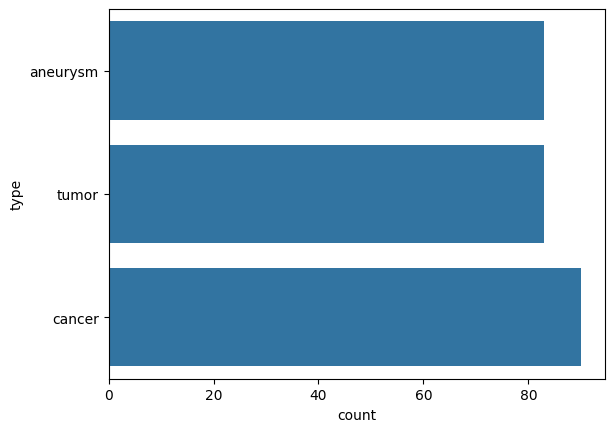

In [ ]:
# Checking balance of target field
sns.countplot(data['type'])

Similar amount for all 3 types - don't need to apply class imbalance techniques

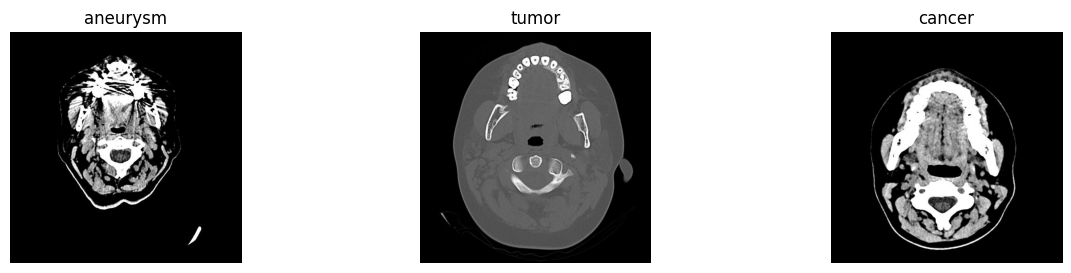

In [ ]:
# Printing an example of each type
classes = data['type'].unique()
num_classes = len(classes)

fig, axs = plt.subplots(1, num_classes, figsize=(15, 3))
for i, class_label in enumerate(classes):
  example = data[data['type'] == class_label].iloc[0]
  path = example['jpg']
  eg_image = cv2.imread(f'/content/drive/MyDrive/files{path}')
  axs[i].imshow(eg_image)
  axs[i].axis('off')
  axs[i].set_title(class_label)
plt.show()

In [ ]:
# Checking for missing data and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dcm     256 non-null    object
 1   jpg     256 non-null    object
 2   type    256 non-null    object
dtypes: object(3)
memory usage: 6.1+ KB


Data type of 'type' field should be integer

In [ ]:
# Performing label encoding to target field
le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])

In [ ]:
# Checking data type for target field has updated
data.dtypes

dcm     object
jpg     object
type     int64
dtype: object

In [ ]:
# Creating array of jpg images using each image path in file
images = []
for i in range(len(data)):
  image = cv2.imread(f'/content/drive/MyDrive/files{data.loc[i, "jpg"]}')
  image = cv2.resize(image, (224, 224)) # Reduced as takes too long to run
  image = image.astype('float32') / 255.0
  images.append(image)

images = np.array(images)

In [ ]:
# Checking shape of array
images.shape

(256, 224, 224, 3)

**Checking for outliers**

In [ ]:
# Reshaping images so 2d
num_images, height, width, depth = images.shape

images_reshaped = images.reshape(num_images, height*width*depth)
images_reshaped.shape

(256, 150528)

In [ ]:
# Reducing dimensions using PCA so can plot
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_reshaped)
images_pca.shape

(256, 2)

In [ ]:
# Visualising PCA components to check for outliers
text = []
for index in range(len(images_pca)):
  text.append(index) # Labelling points with index

# Printing visualisation
px.scatter(x=images_pca[:,0], y=images_pca[:,1], color=data['type'], hover_name=text, title="PCA Visualisation")

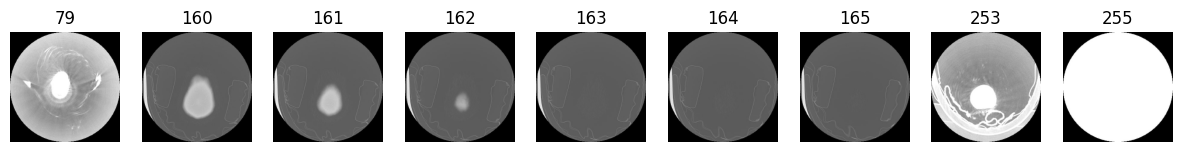

In [ ]:
# Printing images of potential outliers (found by hovering over points on graph which don't follow pattern)
pot_outlier_indexes = [79, 160, 161, 162, 163, 164, 165, 253, 255]

fig, axs = plt.subplots(1, len(pot_outlier_indexes), figsize=(15, 3))
for i, pot_outlier in enumerate(pot_outlier_indexes):
  outlier_image = images[pot_outlier]
  axs[i].imshow(outlier_image)
  axs[i].set_title(pot_outlier)
  axs[i].axis('off')

Only the image with index 255 looks to be an outlier. Therefore, ignoring others.

In [ ]:
# Creating list of outlier indexes - checking if any others in same location, hidden by 255
outlier_indexes = []
print("Indexes of Outliers:")
for i in range(len((images_pca))):
  if images_pca[:,1][i]>100:
    print(i)
    outlier_indexes.append(i)

Indexes of Outliers:
80
81
82
254
255


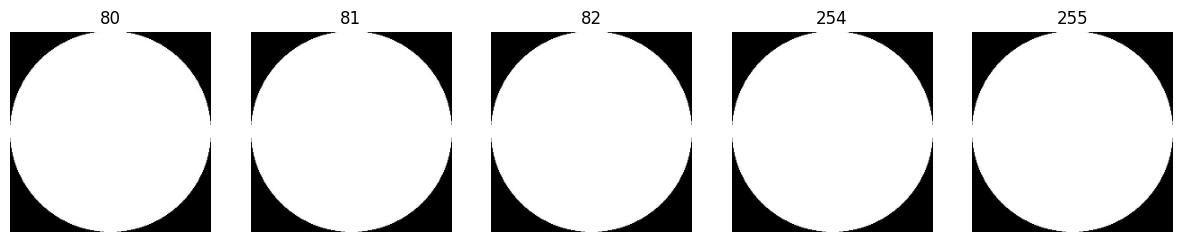

In [ ]:
# Printing images of outliers - checking if all look like outliers
fig, axs = plt.subplots(1, len(outlier_indexes), figsize=(15, 3))
for i, outlier in enumerate(outlier_indexes):
    outlier_image = images[outlier]
    axs[i].imshow(outlier_image)
    axs[i].set_title(outlier)
    axs[i].axis('off')

All visually look like outliers

In [ ]:
# Creating new dataframe without the outliers
data2 = data.drop(outlier_indexes, axis=0)
data2.shape # Checking correct number have been deleted

(251, 3)

In [ ]:
# Recreating images array but without outliers
images2 = []
for i in data2.index.values.tolist():
  image2 = cv2.imread(f'/content/drive/MyDrive/files{data.loc[i, "jpg"]}')
  image2 = cv2.resize(image2, (224, 224)) # Reduced as takes too long to run
  image2 = image2.astype('float32') / 255.0
  images2.append(image2)

images2 = np.array(images2)

In [ ]:
# Checking shape of array is correct
images2.shape

(251, 224, 224, 3)

**Setting up models**

In [ ]:
# Splitting data into test and train (tested using outliers and not)
features = images
#features = images2
target = np.array(data['type'])
#target = np.array(data2['type'])
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

In [ ]:
# Checking shapes
print("Training features shape: ", x_train.shape)
print("Training target shape: ", y_train.shape)
print("Testing features shape: ", x_test.shape)
print("Testing target shape: ", y_test.shape)

Training features shape:  (204, 224, 224, 3)
Training target shape:  (204,)
Testing features shape:  (52, 224, 224, 3)
Testing target shape:  (52,)


In [ ]:
# One-hot encoding labels
y_train_en = tf.keras.utils.to_categorical(y_train, 3)
y_test_en = tf.keras.utils.to_categorical(y_test, 3)

In [ ]:
# Checking now correct shapes
print("Training features shape: ", x_train.shape)
print("Training target shape: ", y_train_en.shape)
print("Testing features shape: ", x_test.shape)
print("Testing target shape: ", y_test_en.shape)

Training features shape:  (204, 224, 224, 3)
Training target shape:  (204, 3)
Testing features shape:  (52, 224, 224, 3)
Testing target shape:  (52, 3)


In [ ]:
# Creating model 1
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
# Creating model 2
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
# Setting up transfer learning model
# Model 3
from tensorflow.keras.applications.vgg16 import VGG16
model = tf.keras.Sequential([
    VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

for layer in model.layers[0].layers:
    layer.trainable = False

In [ ]:
# Compiling model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Viewing layers in model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dropout (Dropout)           (None, 128)               0

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
# Training model
training = model.fit(x_train, y_train_en, epochs=10, validation_data=(x_test, y_test_en))
#training = model.fit(x_train, y_train_en, epochs=10, validation_data=(x_test, y_test_en), callbacks=[early_stopping])

Epoch 1/10
7/7 [==============================] - 21s 3s/step - loss: 46.2187 - accuracy: 0.6765 - val_loss: 18.6219 - val_accuracy: 0.6538
Epoch 2/10
7/7 [==============================] - 19s 3s/step - loss: 5.1786 - accuracy: 0.9461 - val_loss: 7.6062 - val_accuracy: 0.7308
Epoch 3/10
7/7 [==============================] - 18s 3s/step - loss: 5.3062 - accuracy: 0.9657 - val_loss: 6.6129 - val_accuracy: 0.6923
Epoch 4/10
7/7 [==============================] - 18s 3s/step - loss: 5.2557 - accuracy: 0.9461 - val_loss: 10.5568 - val_accuracy: 0.6346
Epoch 5/10
7/7 [==============================] - 19s 3s/step - loss: 0.4493 - accuracy: 0.9951 - val_loss: 3.9157 - val_accuracy: 0.7500
Epoch 6/10
7/7 [==============================] - 18s 3s/step - loss: 0.8297 - accuracy: 0.9755 - val_loss: 3.3866 - val_accuracy: 0.7500
Epoch 7/10
7/7 [==============================] - 18s 3s/step - loss: 2.5358 - accuracy: 0.9804 - val_loss: 4.3971 - val_accuracy: 0.6731
Epoch 8/10
7/7 [===============

**Evaluating Results**

In [ ]:
# Evaluating model
model.evaluate(x_test, y_test_en)

2/2 [==============================] - 1s 373ms/step - loss: 4.3539 - accuracy: 0.8846


[4.353922367095947, 0.8846153616905212]

In [ ]:
# Setting variables for accuracy and loss values
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']
num = np.arange(1, 11)

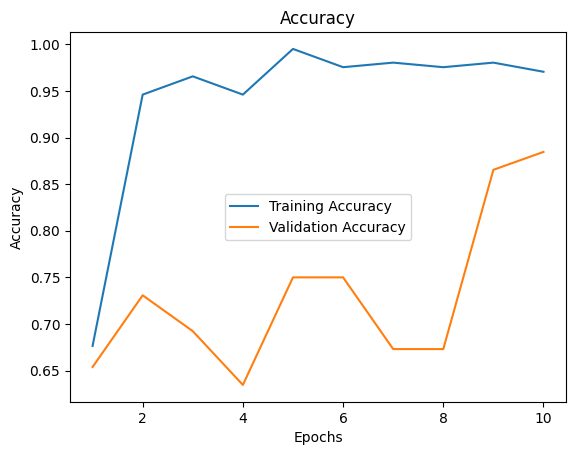

In [ ]:
# Printing training and testing accuracy
plt.plot(num, acc, label="Training Accuracy")
plt.plot(num, val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

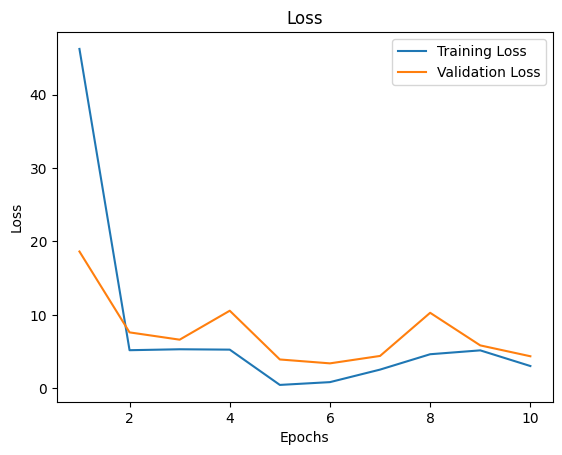

In [ ]:
# Printing training and testing loss
plt.plot(num, loss, label="Training Loss")
plt.plot(num, val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

2/2 [==============================] - 1s 359ms/step


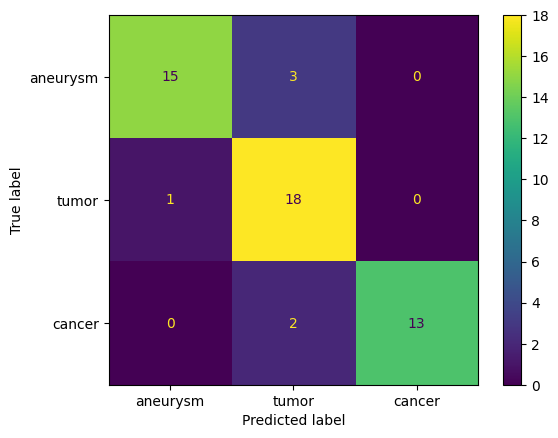

In [ ]:
# Printing confusion matrix of results
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
class_labels = ['aneurysm','tumor', 'cancer']
con_mat = confusion_matrix(y_test, y_pred_class)
con_mat_disp = ConfusionMatrixDisplay(con_mat, display_labels=class_labels)
con_mat_disp.plot()